# データセット

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette="bright")


pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",500)

train = pd.read_csv("/Users/nobu/Documents/データセット/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/Users/nobu/Documents/データセット/house-prices-advanced-regression-techniques/test.csv")

X = train.loc[:,['GrLivArea','YearBuilt']].values
y = train["SalePrice"].values

#訓練用75%と検証用25%に分割
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)


#特徴量を計算・標準化(計算は訓練データのみ)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

# 作成したScratchLinearRegressionクラス

In [2]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, no_bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
        
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する（問題１）
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果
        """
        prediction_result = np.dot(X,self.coef_) 
    
        return prediction_result
    
    def _gradient_descent(self, X,y):
        """
        パラメータ（self.coef_）を更新する。（問題２）
        Parameters
        ----------
        error = _linear_hypothesisで推定したXと、正しい値yの差
        新しいパラメータ = 初期パラメータ - 学習率＊(error・Xの行列積) / Xのサンプル数　

        Returns
        -------
        self.coef_(新しいパラメータ)
        """
        self.coef_ = self.coef_ -  self.lr*np.dot(X.T,self._linear_hypothesis(X) - y)/X.shape[0]

        return self.coef_

    
    def predict(self, X):
        """
        線形回帰を使い推定する。（問題３）
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """      
        prediction_result = np.dot(X,self.coef_)
            
        return prediction_result
    
    def MSE(self,y_pred, y):
        """
        平均二乗誤差の計算（問題４）

        Parameters
        ----------
        y_pred : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
        mse : numpy.float
          平均二乗誤差
        """
        mse = np.sum((y_pred - y)**2)/len(y)
        #np.sum((推測結果 - 実際の値(y))**2)/目的変数のサンプル数(y)    
        
        return mse
    
    def _linear_true(self,y_pred, y):   
        """
        目的関数の算出（問題５）

        Parameters
        ----------
        y_pred : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
        mse : numpy.float
          最小２乗法
        """
        true_result = np.sum((y_pred - y)**2)/len(y)*0.5#平均２乗誤差を1/2
        
        return true_result 

    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # biasの有無でXとself.coef_を調整
        
        if self.no_bias is True:
            X = X
            self.coef_ = np.random.rand((X.shape[1]))
           
        elif self.no_bias is False:
            bias = np.ones(len(X)).reshape(-1, 1)
            X = np.hstack([bias, X])
            if X_val is not None:
                val_bias =  np.ones(len(X_val)).reshape(-1, 1)
                X_val = np.hstack([val_bias, X_val])
                self.coef_ = np.random.rand(X.shape[1])
        
        for i in range(self.iter):
            # パラメータの更新
            self.coef_ = self._gradient_descent(X, y)
            # 目的関数
            self.loss[i] = self._linear_true(self._linear_hypothesis(X), y)      
            if X_val is not None:
                self.val_loss[i] = self._linear_true(self._linear_hypothesis(X_val), y_val)

                #verboseをTrueにした際は学習過程を出力    
                if self.verbose:
                    self.loss[i]
                if X_val is not None:
                        self.val_loss[i]

# 【問題1】仮定関数
====================================================================================================<br>
 以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。

## $$
h_\theta(x) =  \theta_0 x_0 + \theta_1 x_1 + ... + \theta_j x_j + ... +\theta_n x_n.   (x_0 = 1)\\
$$

x: 特徴量ベクトル<br>
θ: パラメータベクトル<br>
n: 特徴量の数<br>
xj: j番目の特徴量<br>
θj: j番目のパラメータ（重み）<br>

特徴量の数nは任意の値に対応できる実装にしてください。なお、ベクトル形式で表すと以下のようになります。
## $$
h_\theta(x) = \theta^T \cdot x.
$$
====================================================================================================<br>

In [3]:
def _linear_hypothesis(self, X):
    """
    線形の仮定関数を計算する（問題１）
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    Returns
    -------
      次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果
    """
    prediction_result = np.dot(X,self.coef_) 

    return prediction_result

# 【問題2】最急降下法
====================================================================================================<br>
#### 最急降下法により学習させる実装を行なってください。
#### 以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。
## $$
\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]
$$

α : 学習率<br>
i : サンプルのインデックス<br>
j : 特徴量のインデックス<br>
====================================================================================================<br>

In [4]:
def _gradient_descent(self, X,y):
    """
    パラメータ（self.coef_）を更新する。（問題２）
    Parameters
    ----------
    error = _linear_hypothesisで推定したXと、正しい値yの差
    新しいパラメータ = 初期パラメータ - 学習率＊(error・Xの行列積) / Xのサンプル数　

    Returns
    -------
    self.coef_(新しいパラメータ)
    """
    error = self._linear_hypothesis(X) - y
    self.coef_ = self.coef_ -  self.lr*np.dot(X.T,self._linear_hypothesis(X) - y)/X.shape[0]

    return self.coef_


# 【問題3】推定
====================================================================================================<br>
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。<br>
仮定関数 hθ(x)の出力が推定結果です。<br>
====================================================================================================<br>

In [5]:
def predict(self, X):
    """
    線形回帰を使い推定する。（問題３）
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        サンプル
    Returns
    -------
        次の形のndarray, shape (n_samples, 1)
        線形回帰による推定結果
    """      
    prediction_result = np.dot(X,self.coef_)

    return prediction_result

# 【問題4】平均二乗誤差
====================================================================================================<br>
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。<br>
平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。<br>
雛形を用意してあります。平均二乗誤差は以下の数式で表されます。<br>
## $$
L(\theta)=  \frac{1 }{ m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$$
m : 入力されるデータの数<br>
hθ(): 仮定関数<br>
x(i): i番目のサンプルの特徴量ベクトル<br>
y(i): i番目のサンプルの正解値<br>

なお、最急降下法のための目的関数（損失関数）としては、これを2で割ったものを使用します。（問題5, 9）<br>
====================================================================================================<br>

In [6]:
def MSE(y_pred, y):
    """
    平均二乗誤差の計算（問題４）

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)　　　#predictで求めた数
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値
    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    mse = np.sum((y_pred - y)**2)/len(y)
    #np.sum((推測結果 - 実際の値(y))**2)/目的変数のサンプル数(y)    

    return mse

# 【問題5】目的関数
====================================================================================================<br>
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。<br>
目的関数（損失関数） J(θ)は次の式です。<br>

## $$
J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$$<br>

m: 入力されるデータの数<br>
hθ(): 仮定関数<br>
x(i) : i番目のサンプルの特徴量ベクトル<br>
y(i): i番目のサンプルの正解値<br>
====================================================================================================<br>

In [7]:
def _linear_true(self,y_pred, y):   
    """
    目的関数の算出（問題５）

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      最小２乗法
    """
    true_result = np.sum((y_pred - y)**2)/len(y)*0.5#平均２乗誤差を1/2

    return true_result 

# 【問題6】学習と推定
====================================================================================================<br>
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。
====================================================================================================<br>

In [8]:
#スクラッチ版
SLR = ScratchLinearRegression(num_iter=1000, lr=0.01, no_bias=True, verbose=False)
SLR.fit(X_train_std,y_train,X_test_std,y_test)
SLR_pred = SLR.predict(X_test)

print(SLR_pred.shape)
print(SLR.MSE(SLR_pred,y_test))

(365,)
1.8535254917820876e+16


In [9]:
#sklearn版
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()
LR.fit(X_train_std,y_train)
LR_pred = LR.predict(X_test_std)

print(LR_pred.shape)
print(mean_squared_error(LR_pred,y_test))

(365,)
1886785549.9599533


# 【問題7】学習曲線のプロット
====================================================================================================<br>
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。


線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。
====================================================================================================<br>

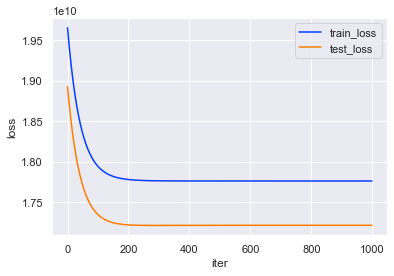

In [10]:
plt.xlabel("iter")
plt.ylabel("loss")
plt.plot(SLR.loss, label=("train_loss"))
plt.plot(SLR.val_loss, label=("test_loss"))
plt.legend()


# 【問題8】（アドバンス課題）バイアス項の削除
====================================================================================================<br>
 バイアス項
 $
 \theta_0
 $
 を削除すると学習がどう変化するか検証してください。<br>また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。
====================================================================================================<br>

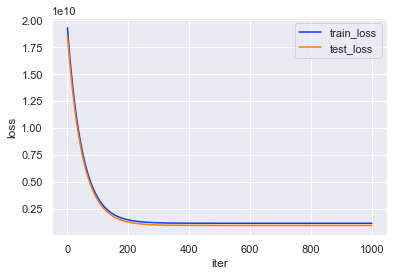

In [11]:
SLR = ScratchLinearRegression(num_iter=1000, lr=0.01, no_bias=False, verbose=False)

SLR.fit(X_train_std,y_train,X_test_std,y_test)

plt.xlabel("iter")
plt.ylabel("loss")
plt.plot(SLR.loss, label=("train_loss"))
plt.plot(SLR.val_loss, label=("test_loss"))
plt.legend()


➡︎
バイアス項を入れたらtrainとtestの損失が一致した。

# 【問題9】（アドバンス課題）特徴量の多次元化
====================================================================================================<br>
特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。
====================================================================================================<br>

(365,)
8.921794799474662e+20


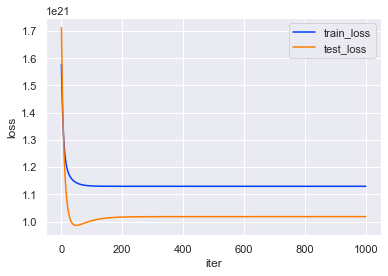

In [12]:
X_train_2 = X_train_std**2
X_test_2 = X_test_std**2
y_train_2 = y_train**2
y_test_2 = y_test**2

#スクラッチ版
SLR = ScratchLinearRegression(num_iter=1000, lr=0.01, no_bias=True, verbose=False)
SLR.fit(X_train_2,y_train_2,X_test_2,y_test_2)
SLR_pred = SLR.predict(X_test_2)

print(SLR_pred.shape)
print(SLR.MSE(SLR_pred,y_test))

plt.xlabel("iter")
plt.ylabel("loss")
plt.plot(SLR.loss, label=("train_loss"))
plt.plot(SLR.val_loss, label=("test_loss"))
plt.legend();

(365,)
inf


/Users/nobu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: overflow encountered in square
/Users/nobu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/nobu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in square


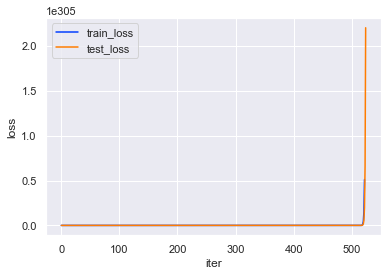

In [13]:
X_train_3 = X_train_std**3
X_test_3 = X_test_std**3
y_train_3 = y_train**3
y_test_3 = y_test**3

#スクラッチ版
SLR = ScratchLinearRegression(num_iter=1000, lr=0.01, no_bias=True, verbose=False)
SLR.fit(X_train_3,y_train_3,X_test_3,y_test_3)
SLR_pred = SLR.predict(X_test_3)

print(SLR_pred.shape)
print(SLR.MSE(SLR_pred,y_test))

plt.xlabel("iter")
plt.ylabel("loss")
plt.plot(SLR.loss, label=("train_loss"))
plt.plot(SLR.val_loss, label=("test_loss"))
plt.legend()

➡︎
３乗からは学習率や繰り返し回数を変えなければMSEが算出できなくなった。